# Deep Learning w/ BERT (NLP)
## Is the job posting Fraudulent or Real?
### Dataset can be found on [Kaggle](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction)
#### Nathan Krasinski


In [1]:
!pip install -q tensorflow-text

     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 6.0 MB 60.2 MB/s 
     |████████████████████████████████| 1.7 MB 70.2 MB/s 
     |████████████████████████████████| 439 kB 86.4 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.4 MB 4.3 MB/s 
     |████████████████████████████████| 238 kB 71.9 MB/s 
     |████████████████████████████████| 118 kB 88.3 MB/s 
     |████████████████████████████████| 1.1 MB 80.1 MB/s 
     |████████████████████████████████| 352 kB 73.7 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 2.3 MB 67.7 MB/s 
     |████████████████████████████████| 1.3 MB 60.4 MB/s 
     |████████████████████████████████| 38.2 MB 310 kB/s 
     |████████████████████████████████| 662 kB 85.5 MB/s 


In [4]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.get_logger().setLevel('ERROR')

In [5]:
df = pd.read_csv("fake_job_postings.csv")

In [6]:
df['combined'] = df['title'].astype(str) + " " + df['description'].astype(str)

## Text Cleanup

In [7]:
import spacy, re

df['combined']=df['combined'].str.replace('\n','')
df['combined']=df['combined'].str.replace('\r','')
df['combined']=df['combined'].str.replace('\t','')
  
#This removes unwanted texts
df['combined'] = df['combined'].apply(lambda x: re.sub(r'[0-9]','',x))
df['combined'] = df['combined'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))
  
#Converting all upper case to lower case
df['combined']= df['combined'].apply(lambda s:s.lower() if type(s) == str else s)
  

#Remove un necessary white space
df['combined']=df['combined'].str.replace('  ',' ')

#Remove Stop words
nlp=spacy.load("en_core_web_sm")
df['combined'] =df['combined'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))

In [8]:
raw_x_train, x_test, raw_y_train, y_test = train_test_split(df['combined'], df['fraudulent'], test_size=0.2, random_state=23, stratify=df['fraudulent'])
x_train, x_val, y_train, y_val = train_test_split(raw_x_train, raw_y_train, test_size=0.25, random_state=23, stratify=raw_y_train)

In [9]:
# Sanity Check
print(x_train.size)
print(y_train.size)
print(x_val.size)
print(y_val.size)
print(x_test.size)
print(y_test.size)


10728
10728
3576
3576
3576
3576


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)


In [11]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [12]:
from keras.activations import sigmoid

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')(text_input)
  Bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')(preprocessing_layer)
  Bert_output = Bert_layer['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(Bert_output)
  output_layer = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, output_layer)  

In [13]:
classifier_model = build_classifier_model()

In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.keras.metrics.AUC(name='auc')

In [15]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [16]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, min_delta=1e-3, restore_best_weights=True)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[early_stopping])


Epoch 1/15
336/336 [==============================] - 51s 118ms/step - loss: 0.2089 - auc: 0.5907 - val_loss: 0.1672 - val_auc: 0.8316
Epoch 2/15
336/336 [==============================] - 36s 107ms/step - loss: 0.1541 - auc: 0.8214 - val_loss: 0.1185 - val_auc: 0.9053
Epoch 3/15
336/336 [==============================] - 35s 105ms/step - loss: 0.1162 - auc: 0.9062 - val_loss: 0.1039 - val_auc: 0.9234
Epoch 4/15
336/336 [==============================] - 36s 106ms/step - loss: 0.0994 - auc: 0.9344 - val_loss: 0.0994 - val_auc: 0.9364
Epoch 5/15
336/336 [==============================] - 33s 99ms/step - loss: 0.0818 - auc: 0.9521 - val_loss: 0.0941 - val_auc: 0.9297
Epoch 6/15
336/336 [==============================] - 35s 105ms/step - loss: 0.0731 - auc: 0.9579 - val_loss: 0.0964 - val_auc: 0.9369
Epoch 7/15
336/336 [==============================] - 38s 113ms/step - loss: 0.0626 - auc: 0.9602 - val_loss: 0.0952 - val_auc: 0.9257
Epoch 8/15
336/336 [==============================] - 36

In [18]:
predictions = classifier_model.predict(val_ds)

112/112 [==============================] - 11s 92ms/step


In [19]:
import numpy as np
pred_class=[0 if p<=0.5 else 1 for p in predictions]

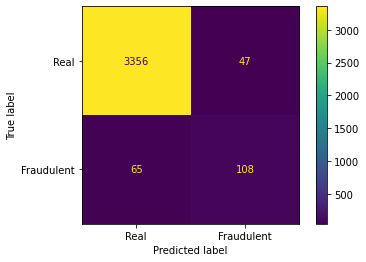

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_val, pred_class, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fraudulent"])
disp.plot()
plt.show()

In [21]:
print(classification_report(y_val, pred_class, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3403
           1       0.70      0.62      0.66       173

    accuracy                           0.97      3576
   macro avg       0.84      0.81      0.82      3576
weighted avg       0.97      0.97      0.97      3576



# Undersampling the data

In [22]:
X = pd.concat([x_train, y_train], axis=1)
legit = X[X.fraudulent == 0] 
fraud = X[X.fraudulent == 1] 





In [23]:
from sklearn.utils import resample
RANDOM_SEED = 23


legit_downsampled = resample(legit,
                                replace = False,
                                n_samples = len(fraud),
                                random_state = RANDOM_SEED)
train_downsampled = pd.concat([legit_downsampled, fraud])
train_downsampled = train_downsampled.sample(frac=1, random_state=RANDOM_SEED).reset_index() #shuffle the dataframe

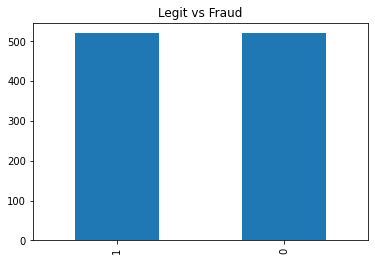

In [24]:
train_downsampled['fraudulent'].value_counts().plot(kind="bar", title="Legit vs Fraud")

In [25]:
train_downsampled_ds = tf.data.Dataset.from_tensor_slices((train_downsampled['combined'], train_downsampled['fraudulent']))
train_downsampled_ds = train_downsampled_ds.batch(32)

In [26]:
ds_model = build_classifier_model()

In [27]:
ds_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [28]:

history_downsampled = ds_model.fit(x=train_downsampled_ds,
                               validation_data=val_ds,
                               epochs=epochs, 
                               callbacks=[early_stopping])

Epoch 1/15
33/33 [==============================] - 15s 295ms/step - loss: 0.6328 - auc: 0.9334 - val_loss: 0.5195 - val_auc: 0.8342
Epoch 2/15
33/33 [==============================] - 7s 223ms/step - loss: 0.5302 - auc: 0.8149 - val_loss: 0.4482 - val_auc: 0.8803
Epoch 3/15
33/33 [==============================] - 9s 269ms/step - loss: 0.4461 - auc: 0.8761 - val_loss: 0.3896 - val_auc: 0.9007
Epoch 4/15
33/33 [==============================] - 8s 259ms/step - loss: 0.3965 - auc: 0.9054 - val_loss: 0.3598 - val_auc: 0.9113
Epoch 5/15
33/33 [==============================] - 8s 262ms/step - loss: 0.3510 - auc: 0.9292 - val_loss: 0.3331 - val_auc: 0.9156
Epoch 6/15
33/33 [==============================] - 8s 256ms/step - loss: 0.3221 - auc: 0.9409 - val_loss: 0.3091 - val_auc: 0.9166
Epoch 7/15
33/33 [==============================] - 9s 278ms/step - loss: 0.2872 - auc: 0.9526 - val_loss: 0.3396 - val_auc: 0.9206
Epoch 8/15
33/33 [==============================] - 8s 242ms/step - loss: 0

In [29]:
predictions_downsampled = ds_model.predict(val_ds)

112/112 [==============================] - 10s 84ms/step


In [30]:
pred_class_ds = [0 if p<=0.5 else 1 for p in predictions_downsampled]

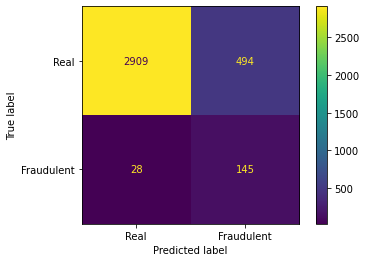

In [31]:
cm_ds = confusion_matrix(y_val, pred_class_ds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ds, display_labels=["Real", "Fraudulent"])
disp.plot()
plt.show()

In [32]:
print(classification_report(y_val, pred_class_ds, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3403
           1       0.23      0.84      0.36       173

    accuracy                           0.85      3576
   macro avg       0.61      0.85      0.64      3576
weighted avg       0.95      0.85      0.89      3576



Undersampling in this case lowered the f1-score, but it predicted fewer fraudulent cases real. Depending on the ultimate goals this may be further tweaked to ensure no Fraudulent case is deemed real.

## Evaluating Classifier model (non-undersampled) As it was the most accurate in testing.

In [33]:
loss, auc = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'AUC: {auc}')

112/112 [==============================] - 10s 92ms/step - loss: 0.0947 - auc: 0.9449
Loss: 0.09471337497234344
AUC: 0.9449456930160522


In [34]:
test_preds = classifier_model.predict(test_ds)

112/112 [==============================] - 12s 105ms/step


In [35]:
pred_class_test =[0 if p<=0.5 else 1 for p in test_preds]

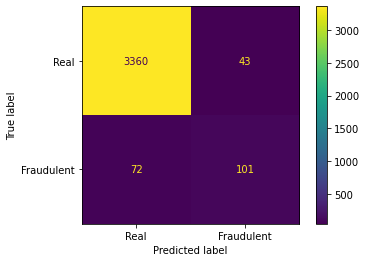

In [36]:
cm_test = confusion_matrix(y_test, pred_class_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Real", "Fraudulent"])
disp.plot()
plt.show()

In [37]:
print(classification_report(y_test, pred_class_test, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3403
           1       0.70      0.58      0.64       173

    accuracy                           0.97      3576
   macro avg       0.84      0.79      0.81      3576
weighted avg       0.97      0.97      0.97      3576



f1 scores of .98 on test data with a near 97% successful prediction rate.